# Using TensorTrade for Making a Simple Trading Algorithm

Sources:

https://www.tensortrade.org/en/latest/tutorials/ray.html

https://levelup.gitconnected.com/using-tensortrade-for-making-a-simple-trading-algorithm-6fad4d9bc79c


In [2]:
from gym.spaces import Discrete

from tensortrade.env.default.actions import TensorTradeActionScheme

from tensortrade.env.generic import ActionScheme, TradingEnv
from tensortrade.core import Clock
from tensortrade.oms.instruments import ExchangePair
from tensortrade.oms.wallets import Portfolio
from tensortrade.oms.orders import (
    Order,
    proportion_order,
    TradeSide,
    TradeType
)

class BSH(TensorTradeActionScheme):
    ''' 
        action: {0: buy asset, 1: sell asset}
    '''
    registered_name = "bsh"

    def __init__(self, cash: 'Wallet', asset: 'Wallet'):
        super().__init__()
        self.cash = cash
        self.asset = asset

        self.listeners = []
        self.action = 0

    @property
    def action_space(self):
        return Discrete(2)

    def attach(self, listener):
        self.listeners += [listener]
        return self

    def get_orders(self, action: int, portfolio: 'Portfolio'):
        order = None

        if abs(action - self.action) > 0:
            src = self.cash if self.action == 0 else self.asset
            tgt = self.asset if self.action == 0 else self.cash
            order = proportion_order(portfolio, src, tgt, 0.2)
            self.action = action

        for listener in self.listeners:
            listener.on_action(action)

        return [order]

    def reset(self):
        super().reset()
        self.action = 0

In [3]:
from tensortrade.env.default.rewards import TensorTradeRewardScheme
from tensortrade.feed.core import Stream, DataFeed


class PBR(TensorTradeRewardScheme):

    registered_name = "pbr"

    def __init__(self, price: 'Stream'):
        super().__init__()
        self.position = -1

        r = Stream.sensor(price, lambda p: p.value, dtype="float").diff()
        position = Stream.sensor(self, lambda rs: rs.position, dtype="float")

        reward = (r * position).fillna(0).rename("reward")

        self.feed = DataFeed([reward])
        self.feed.compile()

    def on_action(self, action: int):
        self.position = -1 if action == 0 else 1

    def get_reward(self, portfolio: 'Portfolio'):
        return self.feed.next()["reward"]

    def reset(self):
        self.position = -1
        self.feed.reset()

In [4]:
import matplotlib.pyplot as plt

from tensortrade.env.generic import Renderer


class PositionChangeChart(Renderer):

    def __init__(self, color: str = "orange"):
        self.color = "orange"

    def render(self, env, **kwargs):
        history = pd.DataFrame(env.observer.renderer_history)
        print(history.columns)

        actions = list(history.action)
        p = list(history.price)
    

        buy = {}
        sell = {}

        for i in range(len(actions) - 1):
            a1 = actions[i]
            a2 = actions[i + 1]

            if a1 != a2:
                if a1 == 0 and a2 == 1:
                    buy[i] = p[i]
                else:
                    sell[i] = p[i]

        buy = pd.Series(buy)
        sell = pd.Series(sell)

        fig, axs = plt.subplots(1, 2, figsize=(15, 5))

        fig.suptitle("Performance")

        axs[0].plot(np.arange(len(p)), p, label="price", color=self.color)
        axs[0].scatter(buy.index, buy.values, marker="^", color="green")
        axs[0].scatter(sell.index, sell.values, marker="^", color="red")
        axs[0].set_title("Trading Chart")
        
#         env.action_scheme.portfolio.performance.plot(ax=axs[1])
        performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')
        print(performance.columns)
        columns = ['bitstamp:/USD:/free','bitstamp:/USD:/locked','bitstamp:/BTC:/free','bitstamp:/BTC:/locked','bitstamp:/BTC:/worth']
        performance.drop(columns, inplace=True, axis=1)
        
        performance.plot(ax=axs[1])
        axs[1].set_title("Net Worth")

        plt.show()

In [5]:
from tensortrade.data.cdd import CryptoDataDownload

cdd = CryptoDataDownload()

data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")
# data = cdd.fetch("Bitstamp", "USD", "BTC", "d")

df = data.copy()

df.describe()

,unix,open,high,low,close,volume
count,2.625000e+04,26250.000000,26250.000000,26250.000000,26250.000000,2.625000e+04
mean,1.573615e+09,13371.040635,13447.250554,13288.156064,13372.554694,2.227501e+06
std,2.728164e+07,14042.233991,14139.264166,13935.976578,14043.945796,7.316888e+06
min,1.526364e+09,3139.760000,3158.340000,3122.280000,3139.760000,0.000000e+00
25%,1.549988e+09,6479.727500,6503.897500,6452.565000,6479.727500,1.301625e+02
50%,1.573616e+09,8658.715000,8704.850000,8621.860000,8658.715000,2.819450e+02
75%,1.597240e+09,11146.287500,11219.570000,11065.452500,11147.870000,9.185575e+02
max,1.620864e+09,64581.810000,64895.220000,64439.740000,64616.800000,2.582324e+08


In [ ]:
def rsi(price: Stream[float], period: float) -> Stream[float]:
    r = price.diff()
    
    upside = r.clamp_min(0).abs()
    downside = r.clamp_max(0).abs()
    rs = upside.ewm(alpha=1 / period).mean() / downside.ewm(alpha=1 / period).mean()
    return 100*(1 - (1 + rs) ** -1)

def macd(price: Stream[float], fast: float, slow: float, signal: float) -> Stream[float]:
    fm = price.ewm(span=fast, adjust=False).mean()
    sm = price.ewm(span=slow, adjust=False).mean()
    md = fm - sm
    signal = md - md.ewm(span=signal, adjust=False).mean()
    return signal

def get_custom_feed(data):
    features = []
    # for c in data.columns[2:]:
    #     s = Stream.source(list(data[c]), dtype="float").rename(data[c].name)
    #     features += [s]
    # cp = Stream.select(features, lambda s: s.name == "close")
    cp = Stream.source(list(df["close"]), dtype="float")
    features = [
        # cp.log().diff().rename("lr"),
        rsi(cp, period=20).rename("rsi"),
        macd(cp, fast=10, slow=50, signal=5).rename("macd")
    ]
    feed = DataFeed(features)
    return feed

# feed.compile()
feed = get_custom_feed(data)
for i in range(5):
    print(feed.next())

In [ ]:
def get_sma_feed(data):
    p = Stream.source(list(data["close"]), dtype="float")
    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])
    return feed

feed = get_sma_feed(data)
for i in range(5):
    print(feed.next())

In [ ]:
def get_raw_feed(data):
    feed = DataFeed([
        Stream.source(data['close'], dtype="float").rename("close"),
        Stream.source(data['open'], dtype="float").rename("open"),
        Stream.source(data['high'], dtype="float").rename("high"),
        Stream.source(data['low'], dtype="float").rename("low"),
        Stream.source(data['volume'], dtype="float").rename("volume"),
    ])
    return feed
feed = get_raw_feed(data)
for i in range(5):
    print(feed.next())

In [ ]:
import ta

def get_ta_feed(data):
    df = data.copy()
    dataset = ta.add_all_ta_features(df, 'open', 'high', 'low', 'close', 'volume', fillna=True)
    price_history = dataset[['date', 'open', 'high', 'low', 'close', 'volume']]  # chart data
    dataset.drop(columns=['date', 'open', 'high', 'low', 'close', 'volume'], inplace=True)
    streams = [Stream.source(dataset[c].tolist(), dtype="float").rename(c) for c in dataset.columns]
    feed = DataFeed(streams)
    return feed

feed = get_ta_feed(data)

feed.next()

In [6]:
import ray
import numpy as np
import pandas as pd

from ray import tune
from ray.tune.registry import register_env

import tensortrade.env.default as default

from tensortrade.feed.core import DataFeed, Stream
from tensortrade.oms.exchanges import Exchange
from tensortrade.oms.services.execution.simulated import execute_order
from tensortrade.oms.wallets import Wallet, Portfolio
from tensortrade.oms.instruments import USD, BTC, ETH

def create_env(config):
    
    p = Stream.source(df.close, dtype="float").rename("USD-BTC")

    bitstamp = Exchange("bitstamp", service=execute_order)(
        p
    )

    cash = Wallet(bitstamp, 10000 * USD)
    asset = Wallet(bitstamp, 0.05 * BTC)

    portfolio = Portfolio(USD, [
        cash,
        asset
    ])
    
    feed = DataFeed([
        p,
        p.rolling(window=10).mean().rename("fast"),
        p.rolling(window=50).mean().rename("medium"),
        p.rolling(window=100).mean().rename("slow"),
        p.log().diff().fillna(0).rename("lr")
    ])

    reward_scheme = PBR(price=p)

    action_scheme = BSH(
        cash=cash,
        asset=asset
    ).attach(reward_scheme)

    renderer_feed = DataFeed([
        Stream.source(df['close'], dtype="float").rename("price"),
        Stream.sensor(action_scheme, lambda s: s.action, dtype="float").rename("action")
    ])

    environment = default.create(
        feed=feed,
        portfolio=portfolio,
        action_scheme=action_scheme,
        reward_scheme=reward_scheme,
        renderer_feed=renderer_feed,
        renderer=PositionChangeChart(),
        window_size=config["window_size"],
        max_allowed_loss=0.2
    )
    return environment

register_env("TradingEnv", create_env)

In [7]:
analysis = tune.run(
    "PPO",
    stop={
      "episode_reward_mean": 8000
    },
    config={
        "env": "TradingEnv",
        "env_config": {
            "window_size": 25
        },
        "log_level": "DEBUG",
        "framework": "torch",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    },
    checkpoint_at_end=True
)



2021-05-13 17:58:45,063	INFO resource_spec.py:223 -- Starting Ray with 2.05 GiB memory available for workers and up to 1.05 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2021-05-13 17:58:45,797	INFO services.py:1191 -- View the Ray dashboard at localhost:8266


Trial name,status,loc
PPO_TradingEnv_8af88_00000,RUNNING,


   'prev_actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.495),
(pid=1587)                         'prev_rewards': np.ndarray((200,), dtype=float32, min=-241.46, max=192.85, mean=-3.734),
(pid=1587)                         'rewards': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=-0.02),
(pid=1587)                         't': np.ndarray((200,), dtype=int64, min=0.0, max=199.0, mean=99.5),
(pid=1587)                         'unroll_id': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1587)                         'value_targets': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=-0.02),
(pid=1587)                         'vf_preds': np.ndarray((200,), dtype=float32, min=-0.667, max=1.138, mean=0.099)},
(pid=1587)               'type': 'SampleBatch'}}
(pid=1587) 
(pid=1587) 2021-05-13 17:59:17,812	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=1587) 
(pid=1587) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,1,28.0781,4000,nan


(pid=1589) 2021-05-13 17:59:42,304	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.4905861308798194, 'policy_loss': -0.003486428060568869, 'vf_loss': 1.0019842516630888, 'vf_explained_var': -0.0077891257, 'kl': 4.236942701388649e-06, 'entropy': 0.691998926922679, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 17:59:42,558	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.4904804197140038, 'policy_loss': -0.002781081944704056, 'vf_loss': 1.000357013195753, 'vf_explained_var': -0.006808428, 'kl': 3.19718973429417e-05, 'entropy': 0.6920220535248518, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 17:59:42,862	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.0007000000000000001, 'total_loss': 0.48729946091771126, 'policy_loss': -0.004909022623905912, 'vf_loss': 0.9982479885220528, 'vf_explained_var': -0.004305538, 'kl': 4.37

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,2,46.0181,8000,nan


(pid=1589) 2021-05-13 18:00:02,040	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.5071135014295578, 'policy_loss': 0.0025398096186108887, 'vf_loss': 1.0227944534271955, 'vf_explained_var': -0.013854623, 'kl': 1.6466027004311684e-05, 'entropy': 0.6825188994407654, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:00:02,341	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.49169776448979974, 'policy_loss': -0.007578558521345258, 'vf_loss': 1.0120649617165327, 'vf_explained_var': -0.010810388, 'kl': 0.0010118225923179125, 'entropy': 0.6857340224087238, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:00:02,654	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 0.00030000000000000003, 'total_loss': 0.4976205579005182, 'policy_loss': -0.0008329230477102101, 'vf_loss': 1.0100914537906647, 'vf_explained_var': -0.009456418, 'kl

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,3,66.0819,12000,nan


      't': np.ndarray((200,), dtype=int64, min=7000.0, max=7199.0, mean=7099.5),
(pid=1587)                         'unroll_id': np.ndarray((200,), dtype=int64, min=35.0, max=35.0, mean=35.0),
(pid=1587)                         'value_targets': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=0.06),
(pid=1587)                         'vf_preds': np.ndarray((200,), dtype=float32, min=-0.211, max=0.096, mean=-0.021)},
(pid=1587)               'type': 'SampleBatch'}}
(pid=1587) 
(pid=1587) 2021-05-13 18:00:18,849	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=1587) 
(pid=1587) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-0.672, max=0.675, mean=0.003),
(pid=1587)             'action_logp': np.ndarray((200,), dtype=float32, min=-1.248, max=-0.231, mean=-0.695),
(pid=1587)             'action_prob': np.ndarray((200,), dtype=float32, min=0.287, max=0.794, mean=0.503),
(pid=1587)             'actions': np.ndarray((200,), dtype=int64, min=0.0, 

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,4,88.2398,16000,nan


(pid=1589) 2021-05-13 18:00:33,560	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=16002, mean_mean=4403.071202016181, mean_std=1245.9717101645665), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1589) 2021-05-13 18:00:47,431	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.5023230873048306, 'policy_loss': 0.0014301875489763916, 'vf_loss': 1.0143877249211073, 'vf_explained_var': -0.013624452, 'kl': 8.402591359900694e-05, 'entropy': 0.6309369634836912, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:00:47,698	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9.400000000000001e-05, 'total_loss': 0.49186758138239384, 'policy_loss': -0.006788211438106373, 'vf_loss': 1.009752057492733, 'vf_explained_var': -0.010991475, 'kl': 0.0011378332310414407, 'entropy': 0.6334010493010283, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:00:47,998	DE

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,5,111.605,20000,nan


(pid=1589) 2021-05-13 18:00:56,952	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=20002, mean_mean=4757.013975572897, mean_std=1509.961374590858), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1589) 2021-05-13 18:01:08,292	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9e-05, 'total_loss': 0.4928451292216778, 'policy_loss': -0.005338890594430268, 'vf_loss': 1.0086307656019926, 'vf_explained_var': -0.012404906, 'kl': 0.0001653595029576481, 'entropy': 0.6147896610200405, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:01:08,558	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 9e-05, 'total_loss': 0.4908598908223212, 'policy_loss': -0.0056590266758576035, 'vf_loss': 1.005082629621029, 'vf_explained_var': -0.008428924, 'kl': 0.0011333719485264737, 'entropy': 0.6135734636336565, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:01:08,882	DEBUG sgd.py:120 -- 2 {'allreduce_l

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,6,133.875,24000,-1609.4


                   'prev_rewards': np.ndarray((200,), dtype=float32, min=-162.92, max=432.27, mean=1.207),
(pid=1587)                         'rewards': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=0.09),
(pid=1587)                         't': np.ndarray((200,), dtype=int64, min=1485.0, max=1684.0, mean=1584.5),
(pid=1587)                         'unroll_id': np.ndarray((200,), dtype=int64, min=61.0, max=61.0, mean=61.0),
(pid=1587)                         'value_targets': np.ndarray((200,), dtype=float32, min=-1.0, max=1.0, mean=0.09),
(pid=1587)                         'vf_preds': np.ndarray((200,), dtype=float32, min=-0.363, max=0.392, mean=0.038)},
(pid=1587)               'type': 'SampleBatch'}}
(pid=1587) 
(pid=1587) 2021-05-13 18:01:20,507	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=1587) 
(pid=1587) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-2.383, max=2.374, mean=-0.001),
(pid=1587)             'action_logp': np.ndar

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,7,153.08,28000,-1609.4


(pid=1589) 2021-05-13 18:01:38,501	DEBUG trainer.py:547 -- synchronized filters: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=28004, mean_mean=5147.156794648797, mean_std=1598.5054653156544), (n=0, mean_mean=0.0, mean_std=0.0))}
(pid=1589) 2021-05-13 18:01:49,362	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 8.2e-05, 'total_loss': 0.5015265299007297, 'policy_loss': 0.0039037871174514294, 'vf_loss': 1.0063500367105007, 'vf_explained_var': -0.010373548, 'kl': 8.763057599239787e-06, 'entropy': 0.5553149562329054, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:01:49,632	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 8.2e-05, 'total_loss': 0.4975564042106271, 'policy_loss': 0.001810682297218591, 'vf_loss': 1.002519641071558, 'vf_explained_var': -0.008123783, 'kl': 0.00031173589968602755, 'entropy': 0.5545272007584572, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:01:49,968	DEBUG sgd.py:120 -- 2 {'allredu

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,8,173.923,32000,-1609.4


(pid=1589) 2021-05-13 18:02:11,331	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.8e-05, 'total_loss': 0.48975145909935236, 'policy_loss': -0.003285904007498175, 'vf_loss': 0.9967722371220589, 'vf_explained_var': -0.0044505354, 'kl': 0.0009803171685613954, 'entropy': 0.544680037535727, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:02:11,605	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.8e-05, 'total_loss': 0.4920830950140953, 'policy_loss': -0.0009952826076187193, 'vf_loss': 0.9969084691256285, 'vf_explained_var': -0.0034957882, 'kl': 0.0006501085954369046, 'entropy': 0.5440867748111486, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:02:11,963	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.8e-05, 'total_loss': 0.48659403063356876, 'policy_loss': -0.004958816396538168, 'vf_loss': 0.9938808046281338, 'vf_explained_var': -0.0025275666, 'kl': 0.001116027373768702, 'entropy': 0.54991

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,9,196.044,36000,-1609.4


-0.035, max=0.22, mean=0.141)},
(pid=1587)               'type': 'SampleBatch'}}
(pid=1587) 
(pid=1587) 2021-05-13 18:02:23,300	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=1587) 
(pid=1587) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-2.611, max=2.616, mean=0.0),
(pid=1587)             'action_logp': np.ndarray((200,), dtype=float32, min=-3.874, max=-0.005, mean=-0.626),
(pid=1587)             'action_prob': np.ndarray((200,), dtype=float32, min=0.021, max=0.995, mean=0.583),
(pid=1587)             'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.585),
(pid=1587)             'advantages': np.ndarray((200,), dtype=float32, min=-1.219, max=0.947, mean=-0.071),
(pid=1587)             'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1587)             'dones': np.ndarray((200,), dtype=bool, min=0.0, max=0.0, mean=0.0),
(pid=1587)             'eps_id': np.ndarray((200,), dtype=int64, min=110471082

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,10,220.405,40000,-1609.4


(pid=1589) 2021-05-13 18:03:02,652	DEBUG sgd.py:120 -- 0 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.000000000000001e-05, 'total_loss': 0.4829601924866438, 'policy_loss': -0.009752932121045887, 'vf_loss': 0.9916798695921898, 'vf_explained_var': -0.0024730433, 'kl': 0.0063130830838565855, 'entropy': 0.37581257801502943, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:03:02,971	DEBUG sgd.py:120 -- 1 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.000000000000001e-05, 'total_loss': 0.4807996489107609, 'policy_loss': -0.010042610752861947, 'vf_loss': 0.9882903601974249, 'vf_explained_var': 0.0013648383, 'kl': 0.004384893258247757, 'entropy': 0.37413989193737507, 'entropy_coeff': 0.01}
(pid=1589) 2021-05-13 18:03:03,351	DEBUG sgd.py:120 -- 2 {'allreduce_latency': 0.0, 'cur_kl_coeff': 0.1, 'cur_lr': 7.000000000000001e-05, 'total_loss': 0.4781661704182625, 'policy_loss': -0.011412862368160859, 'vf_loss': 0.9849217608571053, 'vf_explained_var': 0.003497947, 'kl': 0.

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,11,248.08,44000,-1609.4


0,), dtype=float32, min=-1.0, max=1.0, mean=0.165),
(pid=1587)                         'vf_preds': np.ndarray((200,), dtype=float32, min=-0.189, max=0.448, mean=0.077)},
(pid=1587)               'type': 'SampleBatch'}}
(pid=1587) 
(pid=1587) 2021-05-13 18:03:23,613	INFO rollout_worker.py:594 -- Completed sample batch:
(pid=1587) 
(pid=1587) { 'data': { 'action_dist_inputs': np.ndarray((200, 2), dtype=float32, min=-4.617, max=4.611, mean=0.0),
(pid=1587)             'action_logp': np.ndarray((200,), dtype=float32, min=-3.149, max=-0.0, mean=-0.396),
(pid=1587)             'action_prob': np.ndarray((200,), dtype=float32, min=0.043, max=1.0, mean=0.735),
(pid=1587)             'actions': np.ndarray((200,), dtype=int64, min=0.0, max=1.0, mean=0.59),
(pid=1587)             'advantages': np.ndarray((200,), dtype=float32, min=-1.448, max=1.189, mean=0.088),
(pid=1587)             'agent_index': np.ndarray((200,), dtype=int64, min=0.0, max=0.0, mean=0.0),
(pid=1587)             'dones': np.nda

Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,RUNNING,192.168.0.249:1589,12,270.897,48000,10798.7


Trial name,status,loc,iter,total time (s),ts,reward
PPO_TradingEnv_8af88_00000,TERMINATED,,12,270.897,48000,10798.7


In [8]:
# Get checkpoint
checkpoints = analysis.get_trial_checkpoints_paths(
    trial=analysis.get_best_trial("episode_reward_mean"),
    metric="episode_reward_mean"
)
checkpoint_path = checkpoints[0][0]
print(checkpoint_path)

/Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-13_17-58-49lrd94huy/checkpoint_12/checkpoint-12


In [ ]:
# checkpoint_path = '/Users/yuan/ray_results/PPO/PPO_TradingEnv_0_2021-05-07_21-33-29tqkn893y/checkpoint_5/checkpoint-5'
# ray.init(num_cpus = 1)

In [9]:
import ray.rllib.agents.ppo as ppo

# Restore agent
agent = ppo.PPOTrainer(
    env="TradingEnv",
    config={
        "env_config": {
            "window_size": 25
        },
        "framework": "torch",
        "log_level": "DEBUG",
        "ignore_worker_failures": True,
        "num_workers": 2,
        "num_gpus": 0,
        "clip_rewards": True,
        "lr": 8e-6,
        "lr_schedule": [
            [0, 1e-1],
            [int(1e2), 1e-2],
            [int(1e3), 1e-3],
            [int(1e4), 1e-4],
            [int(1e5), 1e-5],
            [int(1e6), 1e-6],
            [int(1e7), 1e-7]
        ],
        "gamma": 0,
        "observation_filter": "MeanStdFilter",
        "lambda": 0.72,
        "vf_loss_coeff": 0.5,
        "entropy_coeff": 0.01
    }
)
agent.restore(checkpoint_path)

2021-05-13 18:04:05,704	DEBUG rollout_worker.py:957 -- Creating policy for default_policy
2021-05-13 18:04:05,706	DEBUG catalog.py:470 -- Created preprocessor <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f97c613cd00>: Box(-inf, inf, (25, 5), float32) -> (25, 5)
2021-05-13 18:04:05,757	INFO rollout_worker.py:990 -- Built policy map: {'default_policy': <ray.rllib.policy.torch_policy_template.PPOTorchPolicy object at 0x7f97c6127400>}
2021-05-13 18:04:05,758	INFO rollout_worker.py:991 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f97c613cd00>}
2021-05-13 18:04:05,761	DEBUG rollout_worker.py:412 -- Creating policy evaluation worker 0 on CPU (please ignore any CUDA init errors)
2021-05-13 18:04:05,767	INFO rollout_worker.py:446 -- Built filter map: {'default_policy': MeanStdFilter((25, 5), True, True, None, (n=0, mean_mean=0.0, mean_std=0.0), (n=0, mean_mean=0.0, mean_std=0.0))}
2021-05-13 18:04:05,779	DEBUG rollout_w

In [13]:
data = cdd.fetch("Bitstamp", "USD", "BTC", "1h")
# data = cdd.fetch("Bitstamp", "USD", "BTC", "d")

df = data.copy()

df.describe()

df = data.tail(300)
df.tail(20)

,date,unix,open,high,low,close,volume
26230,2021-05-12 05:00:00,1620795600,57431.63,57559.17,57228.52,57293.30,4.362672e+06
26231,2021-05-12 06:00:00,1620799200,57304.94,57409.28,57000.00,57088.66,5.820495e+06
26232,2021-05-12 07:00:00,1620802800,57087.58,57308.44,56950.36,57183.14,5.766508e+06
26233,2021-05-12 08:00:00,1620806400,57156.67,57234.79,56693.32,56981.75,7.099474e+06
26234,2021-05-12 09:00:00,1620810000,56981.72,57263.92,56810.43,56925.44,3.547713e+06
26235,2021-05-12 10:00:00,1620813600,56925.81,56925.81,56048.00,56079.64,7.187501e+06
26236,2021-05-12 11:00:00,1620817200,56096.63,56578.25,56082.65,56481.90,4.952658e+06
26237,2021-05-12 12:00:00,1620820800,56511.25,56708.63,56255.82,56407.71,1.327193e+07
26238,2021-05-12 13:00:00,1620824400,56370.70,56941.98,55869.58,56873.84,1.159127e+07
26239,2021-05-12 14:00:00,1620828000,56878.68,57000.00,56084.06,56124.29,1.499999e+07


Index(['price', 'action'], dtype='object')
Index(['bitstamp:/USD-BTC', 'bitstamp:/USD:/free', 'bitstamp:/USD:/locked',
       'bitstamp:/USD:/total', 'bitstamp:/BTC:/free', 'bitstamp:/BTC:/locked',
       'bitstamp:/BTC:/total', 'bitstamp:/BTC:/worth', 'net_worth',
       'base_symbol'],
      dtype='object')


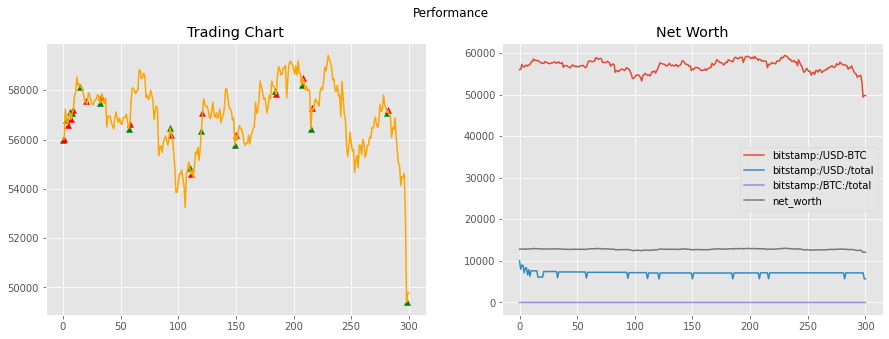

In [14]:
# Instantiate the environment

env = create_env({
    "window_size": 25
})

# Run until episode ends
episode_reward = 0
done = False
obs = env.reset()

# while not done:
for _ in range(len(df.index)):
    action = agent.compute_action(obs)
    obs, reward, done, info = env.step(action)
    # print(env.observer.feed.next())
    episode_reward += reward

env.render()

In [ ]:
performance = pd.DataFrame.from_dict(env.action_scheme.portfolio.performance, orient='index')

from datetime import datetime

today = datetime.today().strftime('%Y-%m-%d')

performance.to_csv('BTC_USD_Performance_{}.csv'.format(today))
performance.plot()

from pandasgui import show
gui = show(performance)

In [ ]:
ledger = env.action_scheme.portfolio.ledger.as_frame()
ledger.to_csv('BTC_USD_ledger_{}.csv'.format(today)')
ledger.plot()

from pandasgui import show
gui = show(ledger)